In [1]:
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 1. Khám phá và tiền xử lý dữ liệu

In [2]:
files = glob('Data/data-covid_*.csv')
df = pd.concat([pd.read_csv(file) for file in files], axis = 0).reset_index(drop = True)
df.head()

,"Country,Other",TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,"Serious,Critical",Tot Cases/1M pop,Deaths/1M pop,TotalTests,Tests/1M pop,Population,Continent,New Cases/1M pop,New Deaths/1M pop,Active Cases/1M pop,Date
0,China,"221,804",+239,"5,209",3.0,"210,454",+448,"6,141",383,154,4,"160,000,000","111,163","1,439,323,776",Asia,0.2,NaN,4,2022-05-15
1,USA,"84,292,674","+50,575","1,026,792",43.0,"81,282,617","+38,479","1,983,265","1,953","251,899","3,068","1,017,059,576","3,039,372","334,628,210",North America,151,0.10,"5,927",2022-05-15
2,India,"43,123,801","+2,202","524,241",27.0,"42,582,243","+2,550","17,317",698,"30,686",373,"844,134,156","600,659","1,405,347,114",Asia,2,0.02,12,2022-05-15
3,Brazil,"30,688,390","+6,296","664,967",47.0,"29,724,682","+6,280","298,741","8,318","142,484","3,087","63,776,166","296,108","215,381,747",South America,29,0.20,"1,387",2022-05-15
4,France,"29,183,646","+22,844","147,352",21.0,"28,170,658","+13,984","865,636","1,329","445,258","2,248","271,490,188","4,142,151","65,543,289",Europe,349,0.30,"13,207",2022-05-15


## 1.1 Dữ liệu có bao nhiêu dòng, cột

In [3]:
num_rows, num_cols = df.shape
print(f'Dữ liệu có {num_rows} dòng')
print(f'Dữ liệu có {num_cols} cột')

Dữ liệu có 4112 dòng
Dữ liệu có 19 cột


## 1.2 Dữ liệu có bị trùng không

In [4]:
num_duplicated = df.drop_duplicates().shape[0] - num_rows
assert num_duplicated == 0

## 1.3 Kiểu dữ liệu và các giá trị khiếm khuyết

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4112 entries, 0 to 4111
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Country,Other        4112 non-null   object 
 1   TotalCases           4112 non-null   object 
 2   NewCases             2117 non-null   object 
 3   TotalDeaths          3971 non-null   object 
 4   NewDeaths            1045 non-null   float64
 5   TotalRecovered       3764 non-null   object 
 6   NewRecovered         1760 non-null   object 
 7   ActiveCases          3764 non-null   object 
 8   Serious,Critical     2641 non-null   object 
 9   Tot Cases/1M pop     4076 non-null   object 
 10  Deaths/1M pop        3932 non-null   object 
 11  TotalTests           3816 non-null   object 
 12  Tests/1M pop         3816 non-null   object 
 13  Population           4078 non-null   object 
 14  Continent            4076 non-null   object 
 15  New Cases/1M pop     2117 non-null   o

- Dữ liệu được cập nhật liên tục nên giá trị thiếu ở một số cột là chuyện bình thường
- Kiểu dữ liệu ở đây khá bất thường, chủ yếu là object, ta sẽ thực hiện tiền xử lý ở đây

###  Tiền xử lý kiểu dữ liệu
- Vấn đề  1: Dữ liệu chứa ',' nên không thể ép về số
- Vấn đề  2: Dữ liệu có dạng '+abc' nên không thể ép về số.
- Vấn đề  3: Dữ liệu chứa N/A do lúc thu thập dữ liệu.
- Vấn đề  4: Kiểu dữ liệu datetime

In [6]:
df.replace(r'\s{2,}',np.nan,inplace = True, regex=True)
df.replace('N/A', np.nan, inplace = True,regex = True)
df.replace(',','', inplace = True, regex = True)
df.replace('\+','', inplace = True, regex = True)
df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')

In [7]:
def convert_to_numeric(col):
    try:
        col = col.str.strip()
        col = col.astype('float64')
    finally:
        return col
    
df = df.apply(convert_to_numeric)
df.dtypes

Country,Other                  object
TotalCases                    float64
NewCases                      float64
TotalDeaths                   float64
NewDeaths                     float64
TotalRecovered                float64
NewRecovered                  float64
ActiveCases                   float64
Serious,Critical              float64
Tot Cases/1M pop              float64
Deaths/1M pop                 float64
TotalTests                    float64
Tests/1M pop                  float64
Population                    float64
Continent                      object
New Cases/1M pop              float64
New Deaths/1M pop             float64
Active Cases/1M pop           float64
Date                   datetime64[ns]
dtype: object

- Kiểu dữ liệu và các giá trị thiếu đã được xử lý xong, ta quay lại khám phá dữ liệu

## 1.4 Khám phá dữ liệu dạng numerical

In [8]:
def missing_ratio(column):
    return (column.isna().mean() * 100).round(2)

def lower_quantile(column):
    return column.quantile(q= 0.25)

def upper_quantile(column):
    return column.quantile(q= 0.75)

In [9]:
numerical_cols = df.select_dtypes('float64')
numerical_cols.aggregate([missing_ratio, pd.Series.min, lower_quantile,
                          pd.Series.mean, upper_quantile, pd.Series.max])

,TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,"Serious,Critical",Tot Cases/1M pop,Deaths/1M pop,TotalTests,Tests/1M pop,Population,New Cases/1M pop,New Deaths/1M pop,Active Cases/1M pop
missing_ratio,0.000000e+00,48.520000,4.300000e+00,74.590000,8.510000e+00,57.220000,8.510000e+00,35.770000,0.88000,4.380000,7.200000e+00,7.200000e+00,1.510000e+00,48.520000,74.930000,3.430000
min,2.000000e+00,1.000000,1.000000e+00,1.000000,1.000000e+00,1.000000,-9.800000e+01,1.000000,16.00000,2.000000,5.117000e+03,5.091000e+03,8.050000e+02,0.020000,-0.110000,-1198.290000
lower_quantile,2.289000e+04,26.000000,2.200000e+02,2.000000,1.542700e+04,27.000000,1.992500e+02,5.000000,11642.00000,152.000000,3.472968e+05,1.649832e+05,5.582655e+05,2.000000,0.200000,101.000000
mean,2.275945e+06,5140.917336,2.860602e+04,26.913876,2.238040e+06,6921.564525,7.465488e+04,269.859523,146845.74264,1153.993388,2.980846e+07,1.936329e+06,3.430633e+07,546.484398,1.815141,25351.819975
upper_quantile,1.097805e+06,932.000000,1.399100e+04,26.000000,1.004620e+06,2476.500000,2.490250e+04,150.000000,253089.25000,1851.000000,1.236498e+07,2.262110e+06,2.197344e+07,227.000000,1.000000,8322.500000
max,8.505519e+07,392930.000000,1.029006e+06,373.000000,8.163215e+07,299190.000000,2.394041e+06,8318.000000,704417.00000,6298.000000,1.021971e+09,2.184665e+07,1.439324e+09,200109.000000,200.000000,547489.000000


- Dữ liệu cập nhật theo ngày nên các cột dữ liệu số thiếu có nghĩa bằng 0 (tức là không có thông tin câp)
- Dự liệu không có gì bất thường

### 1.4.1 Khám phá phân bố của các cột numerical

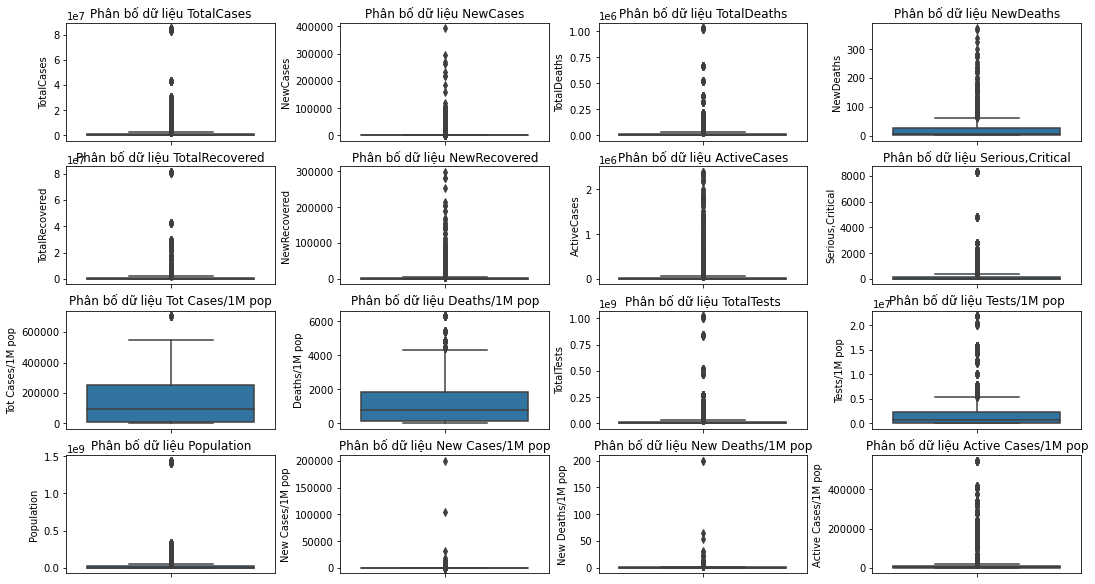

In [10]:
plt.rcParams['figure.figsize'] = 15,8
fig , axs = plt.subplots(4,4,constrained_layout = True)
idx = 0
while idx < numerical_cols.shape[1]:
    r , c = idx // 4, idx % 4 
    sns.boxplot(y = numerical_cols.iloc[:,idx], ax = axs[r,c])
    axs[r,c].set_title(f'Phân bố dữ liệu {numerical_cols.columns[idx]}')
    idx += 1

plt.show()

- Quan sát boxplot của từng cột numerical ta thấy dữ liệu phân bố chưa đều ở nhiều cột
- Tiếp tục tiền xử lý

### 1.4.2 Tiền xử lý outlier: Sử dụng phương pháp IQR

In [11]:
Q1 = numerical_cols.quantile(q = 0.25)
Q3 = numerical_cols.quantile(q = 0.75)
IQR = Q3 - Q1
nonoutlier_num_cols = numerical_cols[~((numerical_cols < Q1 - 1.5*IQR) | \
                                       (numerical_cols > Q3 + 1.5*IQR)).any(axis = 1)]

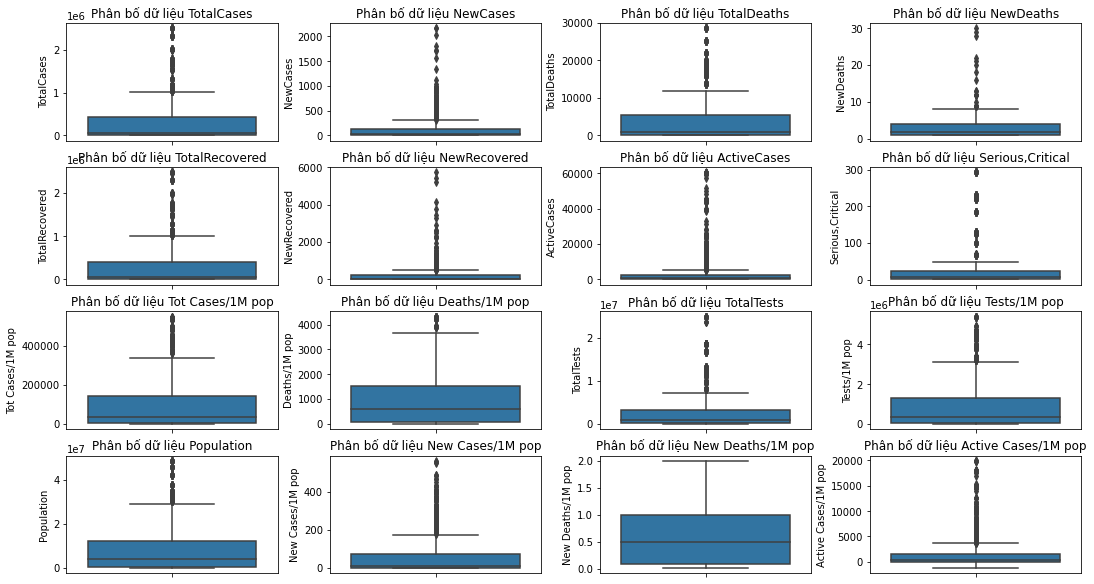

In [12]:
fig , axs = plt.subplots(4,4,constrained_layout = True)
idx = 0
while idx < nonoutlier_num_cols.shape[1]:
    r , c = idx // 4, idx % 4 
    sns.boxplot(y = nonoutlier_num_cols.iloc[:,idx], ax = axs[r,c])
    axs[r,c].set_title(f'Phân bố dữ liệu {nonoutlier_num_cols.columns[idx]}')
    idx += 1
plt.show()

Dữ liệu đã tốt hơn, nhưng một số trường dữ liệu vẫn không khả quan

## 1.5 Khám phá dữ liệu dạng categorical

### 1.5.1 Khám phá thông tin

In [13]:
categorical_cols = df.select_dtypes('O')
categorical_cols.aggregate([missing_ratio, pd.Series.unique, pd.Series.nunique])

,"Country,Other",Continent
missing_ratio,0.0,0.88
unique,"[China, USA, India, Brazil, France, Germany, U...","[Asia, North America, South America, Europe, A..."
nunique,229,6


#### Số lượng châu lục, quốc gia bất thường

In [14]:
df['Continent'].unique()

array(['Asia', 'North America', 'South America', 'Europe',
       'Australia/Oceania', 'Africa', nan], dtype=object)

#### Tiếp tục tiền xử lý dữ liệu

In [15]:
df['Country,Other'] = df['Country,Other'].str.strip()
df['Continent'] = df['Continent'].str.strip()
categorical_cols = df.select_dtypes('O')
categorical_cols.aggregate([missing_ratio, pd.Series.unique, pd.Series.nunique])

,"Country,Other",Continent
missing_ratio,0.0,0.88
unique,"[China, USA, India, Brazil, France, Germany, U...","[Asia, North America, South America, Europe, A..."
nunique,229,6


#### Xem dữ liệu các dòng bị thiếu giá trị Continent

In [16]:
df[df['Continent'].isna()].head()

,"Country,Other",TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,"Serious,Critical",Tot Cases/1M pop,Deaths/1M pop,TotalTests,Tests/1M pop,Population,Continent,New Cases/1M pop,New Deaths/1M pop,Active Cases/1M pop,Date
218,Diamond Princess,712.0,NaN,13.0,NaN,699.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-05-15
224,MS Zaandam,9.0,NaN,2.0,NaN,7.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-05-15
444,Diamond Princess,712.0,NaN,13.0,NaN,699.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-05-10
452,MS Zaandam,9.0,NaN,2.0,NaN,7.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-05-10
672,Diamond Princess,712.0,NaN,13.0,NaN,699.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-04-30


- Theo như nhóm em tìm hiểu thì đây là 2 `du thuyền` mà xuất hiện ổ dịch covid-19 lớn, mà chúng lại không mang giá trị phân tích nào. Do đó em sẽ loại những dòng này

In [17]:
df = df[df['Continent'].notna()]

### 1.5.2 Trực quan hóa `Continent` bằng `bar chart`

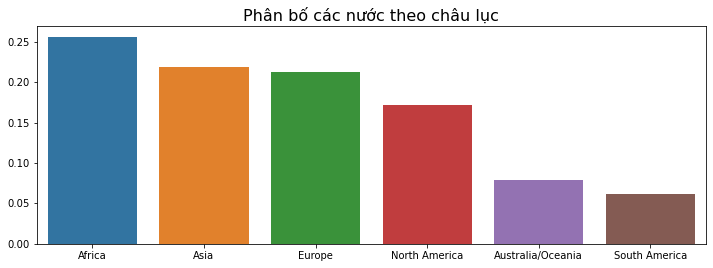

In [18]:
plt.rcParams['figure.figsize'] = 12,4
continent_value = df['Continent'].value_counts(normalize = True)
sns.barplot(x = continent_value.index, y = continent_value.values)
plt.title('Phân bố các nước theo châu lục', fontsize = 16)
plt.show()

- Phân bố không có gì bất thường

## 1.6. Ghi dữ liệu đã chuẩn hóa ra file

In [19]:
df.to_csv('CleanedData/data-covid.csv', index = False)

## 1.7. Phân phối của các cột dữ liệu numerical

Dự vào phần khám phá ở trên, em sẽ chỉ lấy các trường có 'cảm nhận' là tốt đó là `Population`, `Deaths/1M pop`, `Tot Cases/1M pop`

In [20]:
new_df = df[['Population', 'Deaths/1M pop', 'Tot Cases/1M pop']]

Loại bỏ các dòng chứa NaN và 0

In [21]:
new_df = new_df.loc[(df!=0).all(axis=1)].dropna()

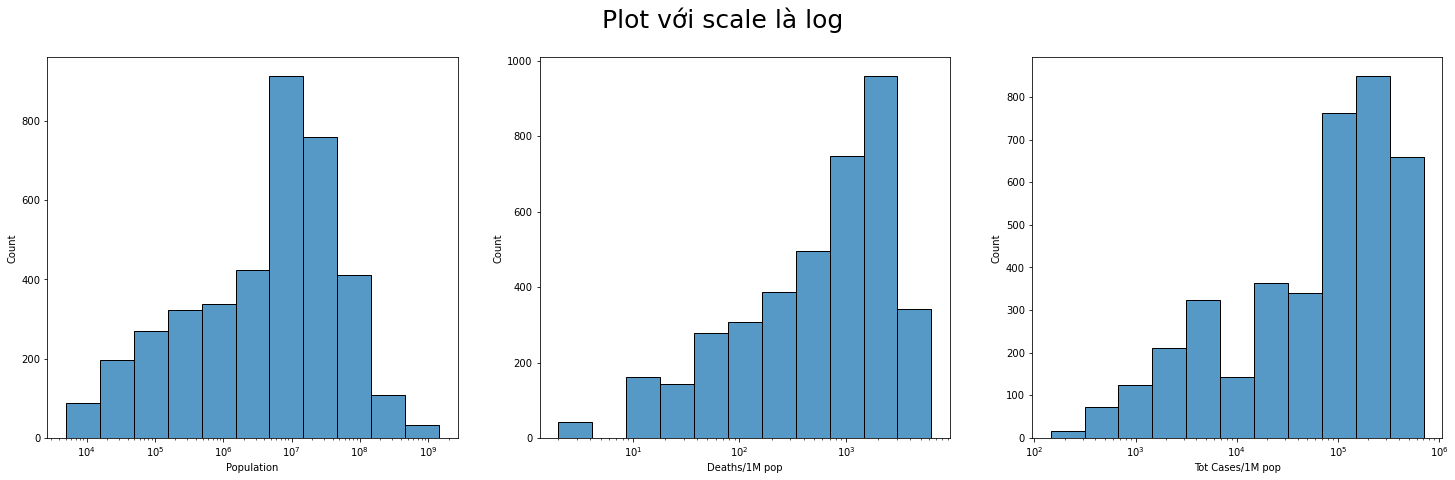

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 7))

for ax in axes.ravel():
    ax.set_xscale('log')
    ax.set_xticks([pow(10, x) for x in range(0, 10)])

sns.histplot(data=new_df, x='Population', ax=axes[0], bins=11)
sns.histplot(data=new_df, x='Deaths/1M pop', ax=axes[1], bins=11)
sns.histplot(data=new_df, x='Tot Cases/1M pop', ax=axes[2], bins=11)

plt.suptitle('Plot với scale là log',fontsize = 25);


**Nhận xét**
- Dân số các quốc gia không đều, tập trung từ 10 triệu đến 50 triệu người. 
- Tổng số ca nhiểm và chết trên 1 triệu dân khá lệch. Tập trung lần lượt là 1 nghìn người và 100 nghìn người

# 2.  Khám phá mối quan hệ giữa các trường dữ liệu

### Trực quan hóa `correlation coefficients`

In [23]:
corr = df.corr()
mask = np.ones_like(corr, dtype=bool)
# trả vể ma trận tam giác trên
mask = np.triu(mask) 
# bỏ đi dòng đầu tiên và cột cuối cùng để visulization dễ nhìn hơn
mask = mask[1:,:-1]
corr = corr.iloc[1:,:-1]

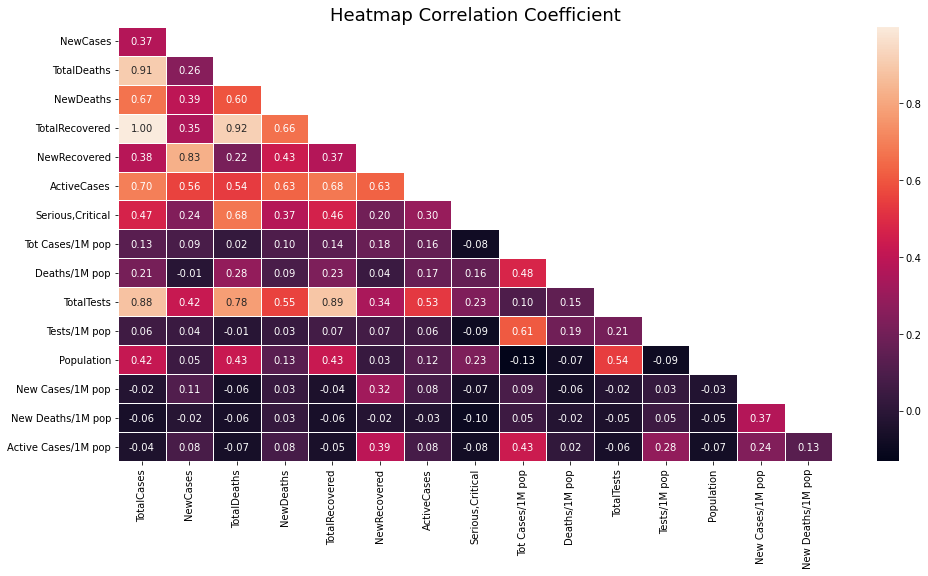

In [24]:
plt.rcParams['figure.figsize'] = 16,8
sns.heatmap(corr, mask = mask, annot = True, 
            fmt = '.2f', linecolor = 'white',linewidths=0.6)
plt.title('Heatmap Correlation Coefficient', fontsize = 18)
plt.show()

- Bằng trực quan Heatmap, ta có thể thấy một số trường thuộc tính có hệ số tương quan cao
     - TotalCases ~ TotalDeaths
     - TotalCases ~ TotalTest
     ....

# 3. Phân tích mối quan hệ giữa các biến phụ thuộc và các biến độc lập

## 3.1 Total Cases ~ Total Deaths

### 1. Trực quan hóa bằng Regplot

/usr/local/lib/python3.10/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


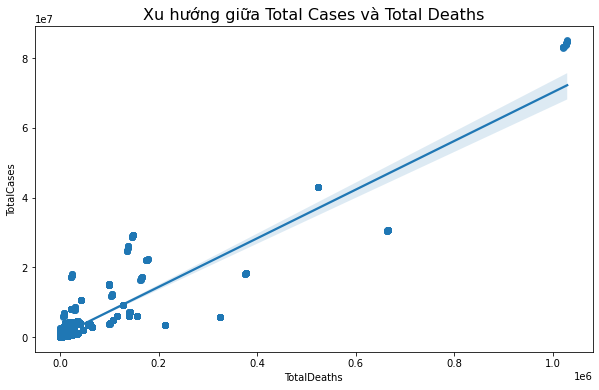

In [25]:
plt.rcParams['figure.figsize'] = (10,6)
sns.regplot('TotalDeaths', 'TotalCases', data = df)
plt.title('Xu hướng giữa Total Cases và Total Deaths', fontsize = 16)
plt.show()

### Nhận xét:
- Qua `Regplot` ta có thể nhận thấy dữ liệu hội tụ và có quan hệ tuyến tính

### 2. Xây dựng mô hình bằng statsmodels

In [26]:
ols_reg = smf.ols('TotalCases ~ TotalDeaths ', data = df).fit()
print(ols_reg.summary())

                            OLS Regression Results                            
Dep. Variable:             TotalCases   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                 1.785e+04
Date:                Wed, 25 May 2022   Prob (F-statistic):               0.00
Time:                        14:20:36   Log-Likelihood:                -63996.
No. Observations:                3899   AIC:                         1.280e+05
Df Residuals:                    3897   BIC:                         1.280e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    3.722e+05   5.42e+04      6.864      

### Nhận xét :
- Các tham số của mô hình có p-value nhỏ nên mô hình có khả năng dự báo tốt
- R-squared cao (82.1%) nên có thể giải thích đa số các trường hợp 

### 3. So sánh Regplot và statsmodels

/usr/local/lib/python3.10/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


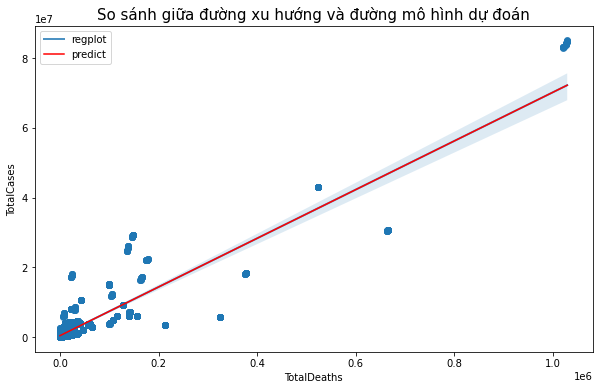

In [27]:
w0, w1 = ols_reg.params
x = np.linspace(0, np.max(df['TotalDeaths']), num = 10000)
y = w0 + w1*x
# TQH
ax = sns.regplot('TotalDeaths', 'TotalCases', data = df,
                line_kws={'alpha': 0.8, 'linewidth': 2, 'label': 'regplot'})
ax.plot(x,y,'red', label='predict')
plt.title('So sánh giữa đường xu hướng và đường mô hình dự đoán', fontsize = 15)
plt.legend()
plt.show()

### Nhận xét :
- Ta thấy đường mô hình `statmodels` dự đoán trùng với đường trend mà `regplot` thể hiện

## 3.2 TotalRecovered ~ ActiveCases + Serious,Critical

### 1. Trực quan hóa bằng Pairplot

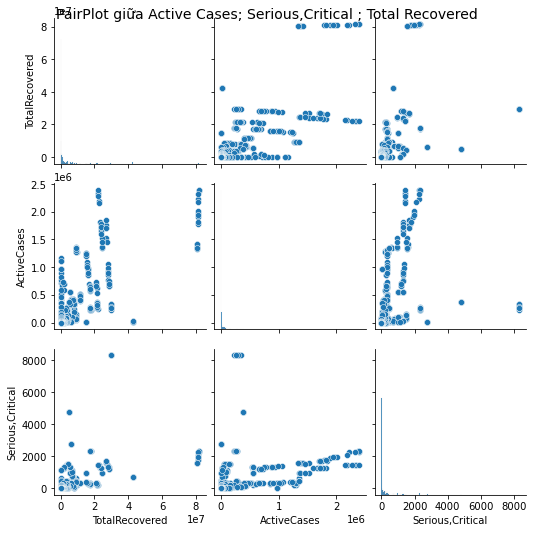

In [28]:
data = df[['TotalRecovered','ActiveCases','Serious,Critical']]
sns.pairplot(data)
plt.suptitle('PairPlot giữa Active Cases; Serious,Critical ; Total Recovered',fontsize = 14)
plt.show()

### 2. Xây dựng mô hình bằng statsmodels

In [29]:
ols_reg = smf.ols('df.TotalRecovered ~ df.ActiveCases + df["Serious,Critical"]', data = df).fit()
print(ols_reg.summary())

                            OLS Regression Results                            
Dep. Variable:      df.TotalRecovered   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     1463.
Date:                Wed, 25 May 2022   Prob (F-statistic):               0.00
Time:                        14:20:40   Log-Likelihood:                -41286.
No. Observations:                2421   AIC:                         8.258e+04
Df Residuals:                    2418   BIC:                         8.260e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               6.38

### Nhận xét:
- Các tham số có p-value nhỏ nên mô hình có khả năng dự đoán tốt
- R-Squared trung bình (54.8%) nhưng mô hình giải thích khá tốt các trường hợp

### 3. Trực quan hóa

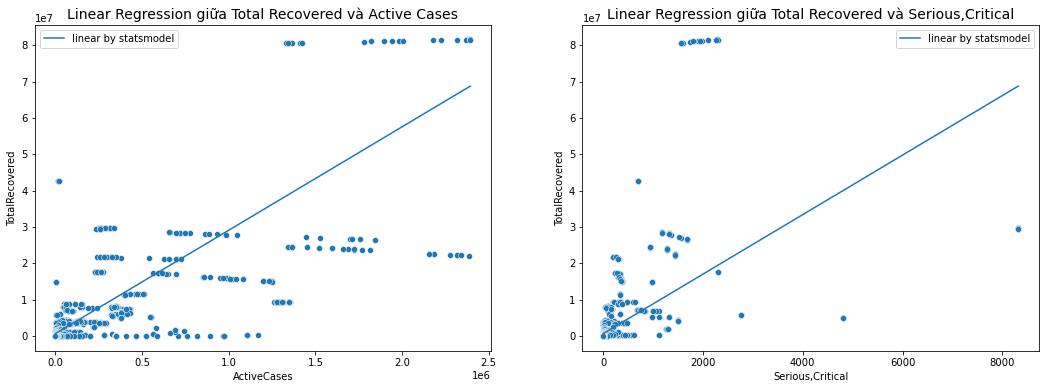

In [30]:
w0, w1 ,w2 = ols_reg.params
x1 = np.linspace(0, np.max(df['ActiveCases']), num = 10000)
x2 = np.linspace(0, np.max(df['Serious,Critical']), num = 10000)
y = w0 + w1*x1 + w2*x2

fig, axs = plt.subplots(1,2,figsize= (18,6))
sns.scatterplot(x = 'ActiveCases', y = 'TotalRecovered', data = df, ax = axs[0])
axs[0].plot(x1,y, label = 'linear by statsmodel')
axs[0].set_title('Linear Regression giữa Total Recovered và Active Cases', fontsize = 14)
axs[0].legend()

sns.scatterplot(x = 'Serious,Critical', y = 'TotalRecovered', data = df, ax = axs[1])
axs[1].plot(x2,y, label = 'linear by statsmodel')
axs[1].set_title('Linear Regression giữa Total Recovered và Serious,Critical', fontsize = 14)
axs[1].legend()
plt.show()

#### Mô hình chưa thực sự dự đoán tốt Total Recovered , nhiều điểm nằm khá xa so với dự đoán

## 3.3 TotalRecovered ~ TotalTests + TotalDeath

### 1. Trực quan hóa bằng Pairplot

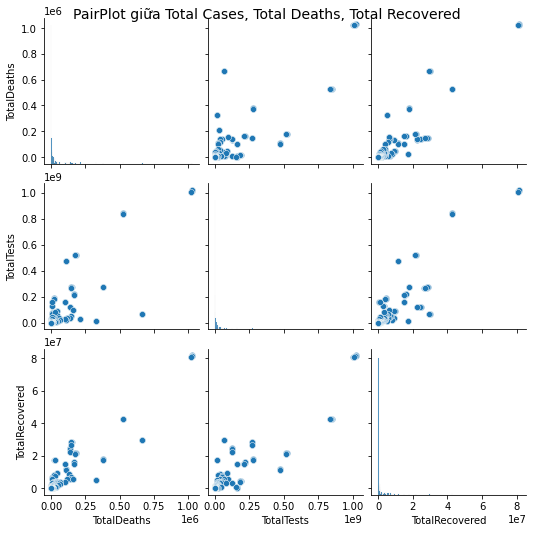

In [31]:
data = df[['TotalDeaths','TotalTests','TotalRecovered']]
sns.pairplot(data)
plt.suptitle('PairPlot giữa Total Cases, Total Deaths, Total Recovered',fontsize = 14)
plt.show()

### 2. Xây dựng mô hình bằng statsmodels

In [32]:
ols_reg = smf.ols('TotalRecovered ~ TotalTests + TotalDeaths', data = df).fit()
print(ols_reg.summary())

                            OLS Regression Results                            
Dep. Variable:         TotalRecovered   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                 1.891e+04
Date:                Wed, 25 May 2022   Prob (F-statistic):               0.00
Time:                        14:20:45   Log-Likelihood:                -55435.
No. Observations:                3454   AIC:                         1.109e+05
Df Residuals:                    3451   BIC:                         1.109e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1.703e+05   4.02e+04      4.239      

### Nhận xét:
- Các tham số của mô hình có p-value nhỏ nên mô hình có khả năng dự báo tốt
- R-squared cao (91,6%) nên có thể giải thích trong đa số trường hợp 

### 3. Trực quan hóa Linear Regression

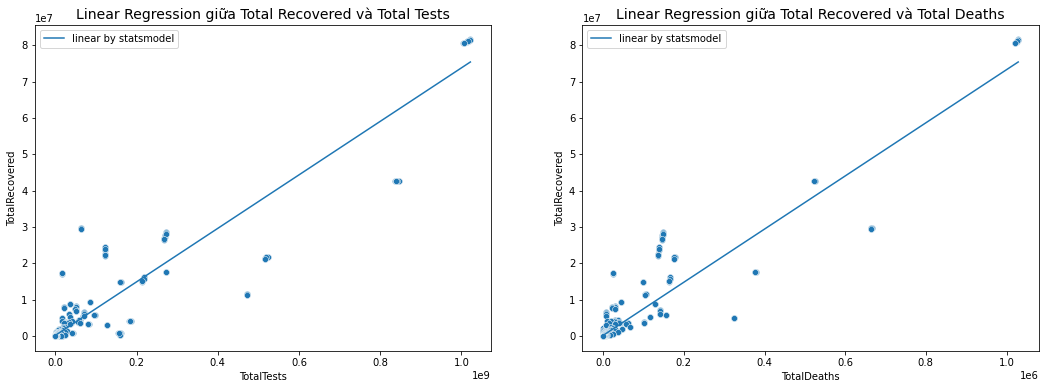

In [33]:
w0, w1, w2 = ols_reg.params
x1 = np.linspace(0, np.max(df['TotalTests']), num = 10000)
x2 = np.linspace(0, np.max(df['TotalDeaths']), num = 10000)
y = w0 + w1*x1 + w2*x2

fig, axs = plt.subplots(1,2,figsize= (18,6))
sns.scatterplot(x = 'TotalTests', y = 'TotalRecovered', data = df, ax = axs[0])
axs[0].plot(x1,y, label = 'linear by statsmodel')
axs[0].set_title('Linear Regression giữa Total Recovered và Total Tests', fontsize = 14)
axs[0].legend()

sns.scatterplot(x = 'TotalDeaths', y = 'TotalRecovered', data = df, ax = axs[1])
axs[1].plot(x2,y, label = 'linear by statsmodel')
axs[1].set_title('Linear Regression giữa Total Recovered và Total Deaths', fontsize = 14)
axs[1].legend()

plt.show()

## 3.4 TotalRecoved ~ TotalTests + TotalDeaths + TotalTests * TotalDeaths

### 1. Xây dựng mô hình bằng statsmodels

In [34]:
ols_reg = smf.ols('TotalRecovered ~ TotalTests + TotalDeaths + TotalTests*TotalDeaths', data = df).fit()
print(ols_reg.summary())

                            OLS Regression Results                            
Dep. Variable:         TotalRecovered   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                 1.318e+04
Date:                Wed, 25 May 2022   Prob (F-statistic):               0.00
Time:                        14:20:45   Log-Likelihood:                -55364.
No. Observations:                3454   AIC:                         1.107e+05
Df Residuals:                    3450   BIC:                         1.108e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               3.08

### Nhận xét :
- Mô hình có p-value nhỏ nên mô hình có khả năng dự báo tốt
- R-Squared cao (92%), tốt hơn khi chưa dùng thêm tham số phụ, nên mô hình có thể giải thích đa số các trường hợp


### 2. Trực quan hóa

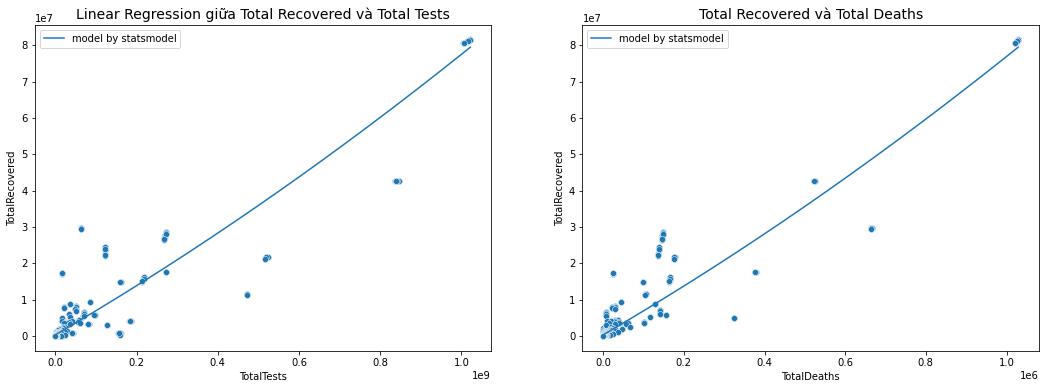

In [35]:
w0, w1, w2, w3 = ols_reg.params
x1 = np.linspace(0, np.max(df['TotalTests']), num = 10000)
x2 = np.linspace(0, np.max(df['TotalDeaths']), num = 10000)
y = w0 + w1*x1 + w2*x2 + w3*(x1*x2)

fig, axs = plt.subplots(1,2,figsize= (18,6))
sns.scatterplot(x = 'TotalTests', y = 'TotalRecovered', data = df, ax = axs[0])
axs[0].plot(x1,y, label = 'model by statsmodel')
axs[0].set_title('Linear Regression giữa Total Recovered và Total Tests', fontsize = 14)
axs[0].legend()

sns.scatterplot(x = 'TotalDeaths', y = 'TotalRecovered', data = df, ax = axs[1])
axs[1].plot(x2,y, label = 'model by statsmodel')
axs[1].set_title('Total Recovered và Total Deaths', fontsize = 14)
axs[1].legend()

plt.show()

### Nhận xét:
- Bằng việc thêm tham số `TotalTest * TotalDeaths` mà việc dự đoán đã trở nên tốt hơn

# 4. Phân tích mối quan hệ giữa các biến định tính, quan hệ nhân quả

## 4.1 TotalTests ~ Continents_ordinal

### 1. Trực quan hóa bằng Violinplot

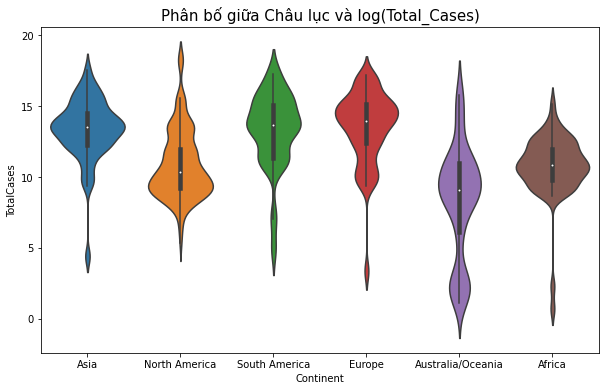

In [36]:
sns.violinplot(y = np.log(df['TotalCases']), x  = 'Continent', data = df)
plt.title("Phân bố giữa Châu lục và log(Total_Cases)", fontsize = 15)
plt.show()

### Nhận xét:
- Dữ liệu ở từng châu lục có phân bố khá giống nhau từ độ tập trung đến mật độ giá trị. 
- Chỉ riêng `Australia/Oceania` có miền giá trị và mật độ phân bố rộng hơn.

### 2. Tính hệ số tương quan Spearman và xây dựng mô hình bằng statsmodel

In [37]:
# label encoding cho cột Continent 
cat = df['Continent'].astype('category').cat
df['Continent_ordinal'] = cat.codes
d = dict(enumerate(cat.categories))
d

{0: 'Africa',
 1: 'Asia',
 2: 'Australia/Oceania',
 3: 'Europe',
 4: 'North America',
 5: 'South America'}

In [38]:
corr, pvalue = stats.spearmanr(df['Continent_ordinal'], df['TotalTests'],nan_policy='omit')
print(f'Hệ số tương quan Spearman: {corr}')
print(f'Giá trị p-value: {pvalue}')

Hệ số tương quan Spearman: 0.0357461003722618
Giá trị p-value: 0.027233539843436513


### Nhận xét : pvalue < 0.05, correlation score nhỏ
- Giữa `Total Tests` và `Continent` hầu như không có mối tương quan tuyến tính

In [39]:
ols_reg = smf.ols('TotalTests ~ Continent_ordinal', data = df).fit()
print(ols_reg.summary())

                            OLS Regression Results                            
Dep. Variable:             TotalTests   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     23.43
Date:                Wed, 25 May 2022   Prob (F-statistic):           1.35e-06
Time:                        14:20:46   Log-Likelihood:                -75972.
No. Observations:                3816   AIC:                         1.519e+05
Df Residuals:                    3814   BIC:                         1.520e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1.943e+07   2.76e+0

### Nhận xét :
- Condition number rất nhỏ nên mô hình chưa tốt mặc dù p-value có ý nghĩa thống kê
- R-Squared thấp (0.6%) nên không thể giải thích được đa số trường hợp
- Kết quả nhận được từ Summary của statsmodels rất hợp lý với độ đo Spearman
#### Mô hình trên chưa tốt nên ta sẽ tìm mô hình tốt hơn

### 3. Trực quan hóa Linear Regression

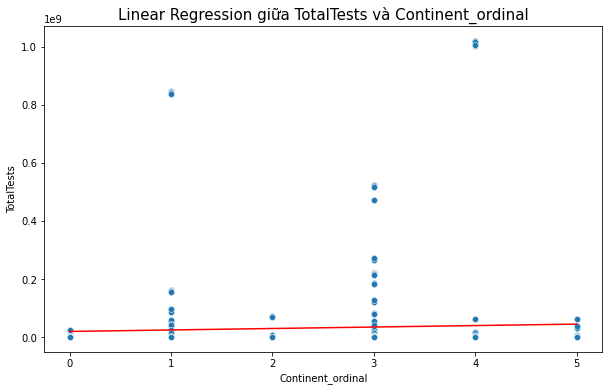

In [40]:
w0, w1 = ols_reg.params
x = np.linspace(0, np.max(df['Continent_ordinal']), num = 10000)
y = w0 + w1*x
ax = sns.scatterplot(x = 'Continent_ordinal', y = 'TotalTests', data = df)
ax.plot(x,y, 'red')
plt.title('Linear Regression giữa TotalTests và Continent_ordinal', fontsize =15)
plt.show()

## 4.2 TotalTests ~ Population + Continent_ordinal + Population * Continent_ordinal

### 1.Trực quan hóa bằng Pairplot

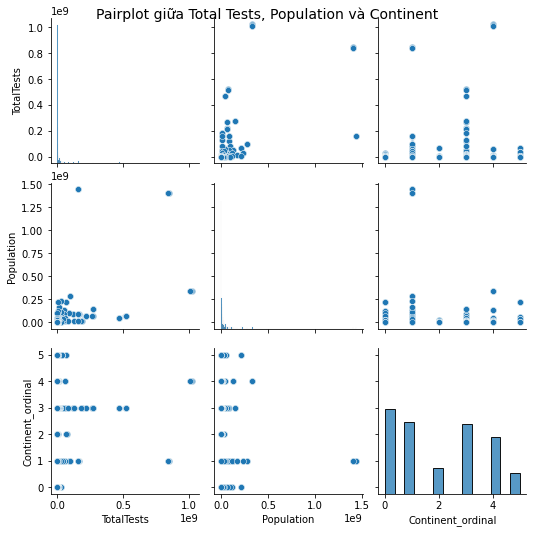

In [41]:
data = df[['TotalTests','Population','Continent_ordinal']]
sns.pairplot(data)
plt.suptitle('Pairplot giữa Total Tests, Population và Continent', fontsize = 14)
plt.show()

### 2. Xây dựng mô hình bằng statsmodels

In [42]:
ols_reg = smf.ols('TotalTests ~ Population + Continent_ordinal + Population * Continent_ordinal ', data = df).fit()
print(ols_reg.summary())

                            OLS Regression Results                            
Dep. Variable:             TotalTests   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     1374.
Date:                Wed, 25 May 2022   Prob (F-statistic):               0.00
Time:                        14:20:50   Log-Likelihood:                -74091.
No. Observations:                3792   AIC:                         1.482e+05
Df Residuals:                    3788   BIC:                         1.482e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

### Nhận xét: 
- Các tham số của mô hình có p-value nhỏ nên mô hình có khả năng dự đoán tốt
- R-squared trung bình(52.1%) nên mô hình giải thích tương đối các trường hợp.

### 3. Trực quan hóa

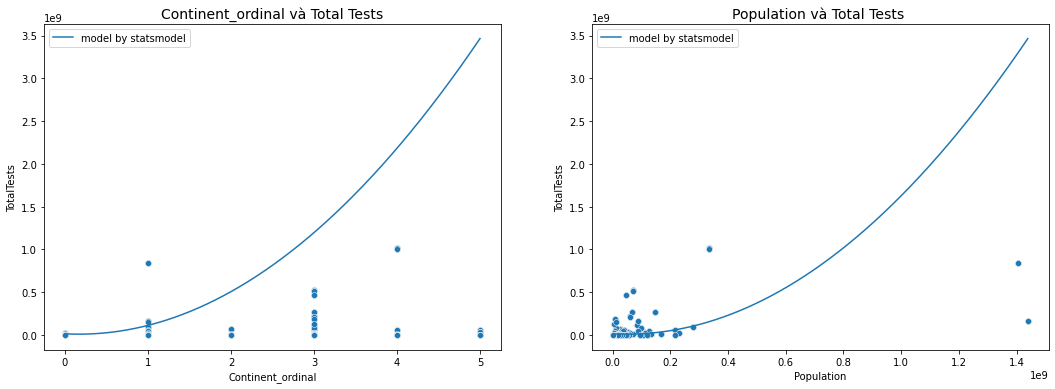

In [43]:
w0, w1, w2, w3 = ols_reg.params
x1 = np.linspace(0, np.max(df['Population']), num = 10000)
x2 = np.linspace(0, np.max(df['Continent_ordinal']), num = 10000)
y = w0 + w1*x1 + w2*x2 + w3*(x1*x2)

fig, axs = plt.subplots(1,2,figsize= (18,6))
sns.scatterplot(x = 'Continent_ordinal', y = 'TotalTests', data = df, ax = axs[0])
axs[0].plot(x2,y, label = 'model by statsmodel')
axs[0].set_title('Continent_ordinal và Total Tests', fontsize = 14)
axs[0].legend()

sns.scatterplot(x = 'Population', y = 'TotalTests', data = df, ax = axs[1])
axs[1].plot(x1,y, label = 'model by statsmodel')
axs[1].set_title('Population và Total Tests ', fontsize = 14)
axs[1].legend()
plt.show()

#### Mô hình tốt hơn trong việc dự báo xu hướng tăng của Total Tests

# 5. Phân tích quan hệ theo thời gian 

## 5.1 Phân tích New Cases giữa các châu lục theo thời gian

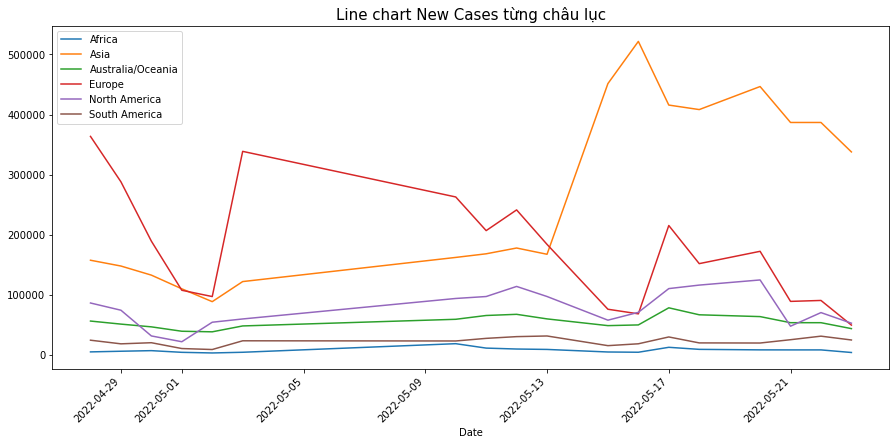

In [44]:
plt.rcParams['figure.figsize'] = 15,7
pivot = pd.pivot_table(values = 'NewCases', columns = 'Continent', index = 'Date', data = df, aggfunc='sum')
ax = pivot.plot.line()
ax.tick_params(axis = 'x', labelrotation = 45)
plt.title('Line chart New Cases từng châu lục', fontsize = 15)
plt.legend(loc = 'upper left')
plt.show()

### Nhận xét :
- Số ca mới giữa các châu lục có xu hướng khác nhau.
- Châu Á tăng nhanh, châu Âu tăng, giảm liên tục, còn các châu lục khác không thay đổi đáng kể dù có tăng
- Vì dữ liệu hạn chế nên chưa thể thấy được tính xu hướng của dữ liệu

### 1. Trực quan hóa hàm tự tương quan ACF

In [45]:
from statsmodels.graphics.tsaplots import plot_acf

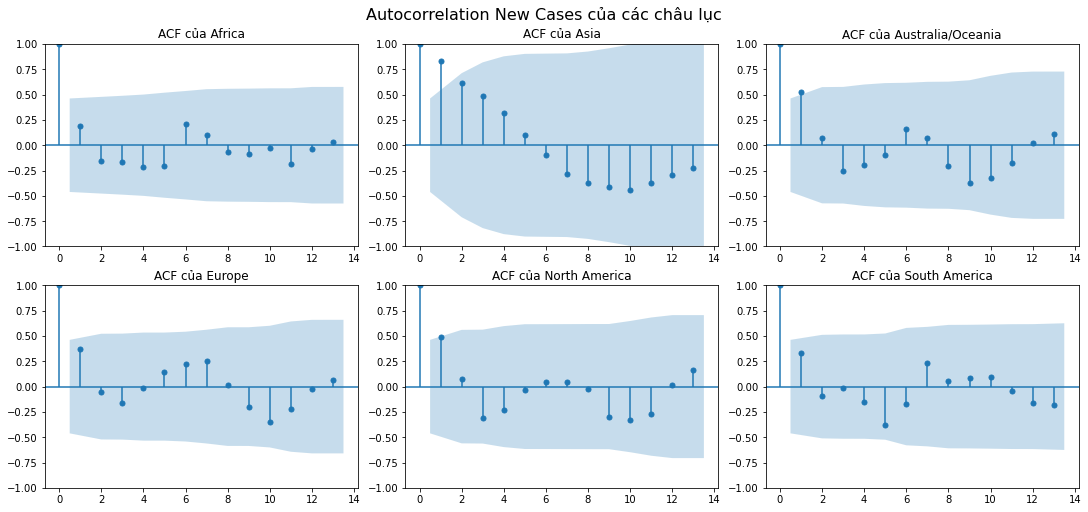

In [46]:
fig ,axs = plt.subplots(2,3, constrained_layout = True)

continent = pivot.columns
idx = 0
while idx < 6:
    i = idx // 3
    j = idx % 3
    plot_acf(pivot[continent[idx]], ax = axs[i,j])
    axs[i,j].set_title(f'ACF của {continent[idx]}')
    idx += 1

plt.suptitle('Autocorrelation New Cases của các châu lục', fontsize = 16)
plt.show()

### Nhận xét :
- Ta dễ dàng nhận thấy Asia có tính `tự tương quan âm hoàn hảo`, các châu lục còn lại có tính tự tương quan âm
- Như vậy có thể dự đoán trong tương lai New Cases ở Asia có xu hướng giảm

### 2. Trực quan độ trễ cho hàm ACF

In [47]:
from pandas.plotting import lag_plot

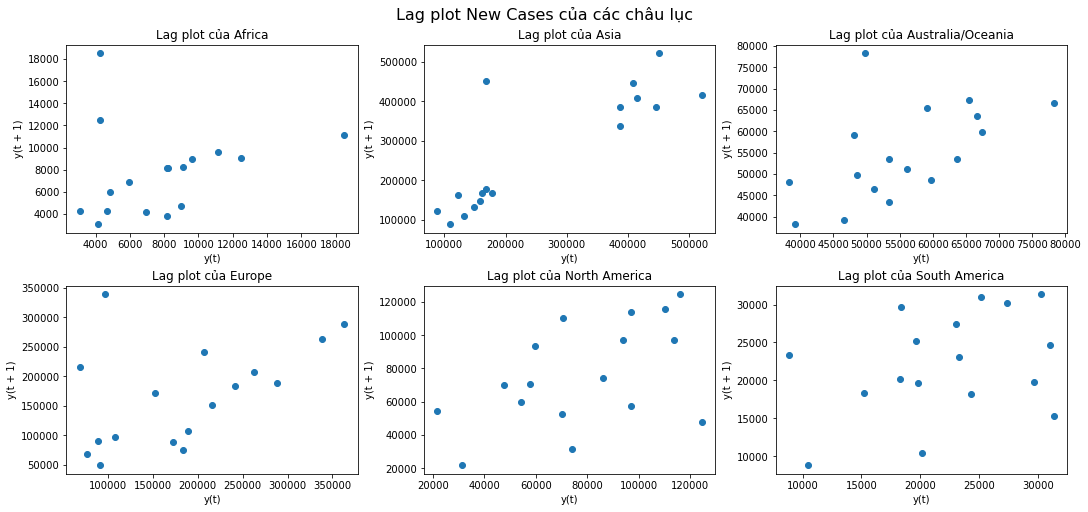

In [48]:
fig ,axs = plt.subplots(2,3, constrained_layout = True)

continent = pivot.columns
idx = 0
while idx < 6:
    i = idx // 3
    j = idx % 3
    lag_plot(pivot[continent[idx]], ax = axs[i,j])
    axs[i,j].set_title(f'Lag plot của {continent[idx]}')
    idx += 1

plt.suptitle('Lag plot New Cases của các châu lục', fontsize = 16)
plt.show()

## 5.2 Phân tích New Deaths giữa các châu lục theo thời gian

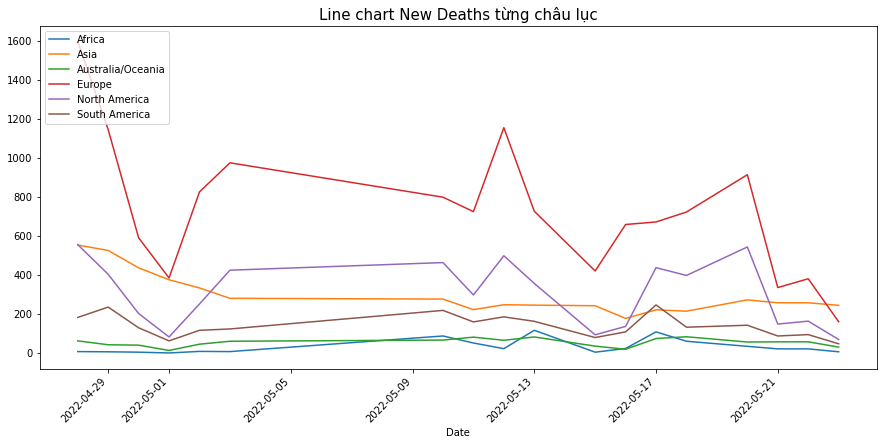

In [49]:
plt.rcParams['figure.figsize'] = 15,7
pivot = pd.pivot_table(values = 'NewDeaths', columns = 'Continent', index = 'Date', data = df, aggfunc='sum')
ax = pivot.plot.line()
ax.tick_params(axis = 'x', labelrotation = 45)
plt.title('Line chart New Deaths từng châu lục', fontsize = 15)
plt.legend(loc = 'upper left')
plt.show()

### 1. Trực quan hóa hàm tự tương quan ACF

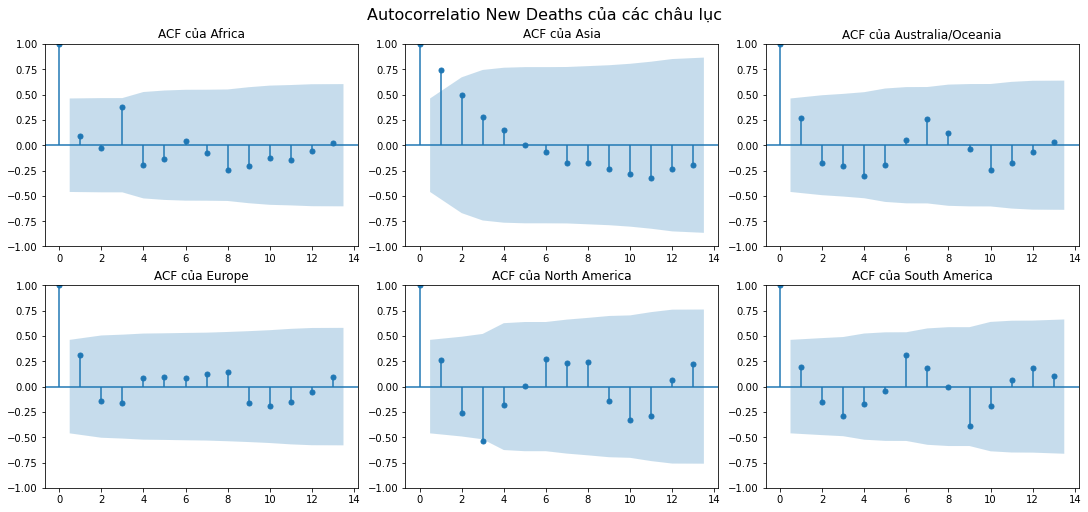

In [50]:
fig ,axs = plt.subplots(2,3, constrained_layout = True)

continent = pivot.columns
idx = 0
while idx < 6:
    i = idx // 3
    j = idx % 3
    plot_acf(pivot[continent[idx]], ax = axs[i,j])
    axs[i,j].set_title(f'ACF của {continent[idx]}')
    idx += 1

plt.suptitle('Autocorrelatio New Deaths của các châu lục', fontsize = 16)
plt.show()

### Nhận xét :
- Ta dễ dàng nhận thấy Asia có tính `tự tương quan âm hoàn hảo`, các châu lục còn lại có tính tự tương quan âm
- Như vậy có thể dự đoán trong tương lai New Deaths ở Asia có xu hướng giảm

### 2. Trực quan độ trễ cho hàm ACF

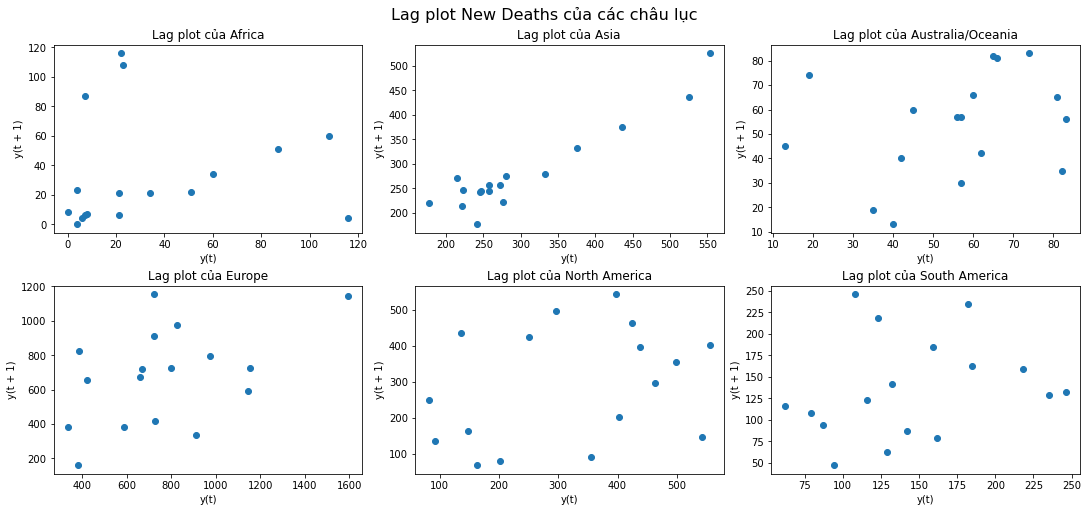

In [51]:
fig ,axs = plt.subplots(2,3, constrained_layout = True)

continent = pivot.columns
idx = 0
while idx < 6:
    i = idx // 3
    j = idx % 3
    lag_plot(pivot[continent[idx]], ax = axs[i,j])
    axs[i,j].set_title(f'Lag plot của {continent[idx]}')
    idx += 1

plt.suptitle('Lag plot New Deaths của các châu lục', fontsize = 16)
plt.show()

# 6. Xây dưng mô hình học máy

## Đặt vấn đề : Dựa vào các thông tin như NewCases, NewDeaths, Serious & Critical,... để phân biệt quốc gia đó thuộc châu lục nào.

In [95]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer

### 1. Xử lý giá trị thiếu

In [96]:
X = df[['NewCases','NewDeaths','Serious,Critical','ActiveCases']]
y = df['Continent_ordinal']

# fill missing by mean value
imp = SimpleImputer(missing_values=np.nan, strategy='mean').fit(X)
X   = imp.transform(X)

# split train, test
X_train,X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

### 2. Dùng DecisionTreeClassification để huấn luận

In [97]:
tree = DecisionTreeClassifier()
model = tree.fit(X_train, y_train)

predict_train = model.predict(X_train)
accuracy_train = accuracy_score(y_train,predict_train)
print(f'Accuracy score of train: {accuracy_train}')

Accuracy score of train: 0.9564417177914111


### Nhận xét : 
- Kết quả trên tập train cao

### 3. Dự đoán trên tập test

In [98]:
predict_test = model.predict(X_test)
accuracy_test = accuracy_score(y_test,predict_test)
print(f'Accuracy score of train: {accuracy_test}')

Accuracy score of train: 0.8419117647058824


In [99]:
y_predict = np.concatenate([predict_train,predict_test])
precision = precision_score(y, y_predict, average='micro')
print(f'precision score: {precision}')
recall = recall_score(y, y_predict, average='micro')
print(f'recall score: {recall}')

precision score: 0.1997055937193327
recall score: 0.1997055937193327


### Nhận xét :
- Kết quả trên tập test cao nhưng chưa thể kết luận mô hình tốt vì precision score, recall score khá thấp. 
- Vậy mô hình bị unbalanced giữa các quốc gia trong châu lục.